In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import cv2


In [2]:

# -------------------------
# 1. Conjunto de Dados CIFAR-10
# -------------------------
# Carregamos o conjunto de dados CIFAR-10, que contém 6 imagens de 32x32 pixels
# divididas em 10 classes. As imagens são normalizadas para o intervalo [0, 1].
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Definimos os nomes das classes para facilitar a interpretação dos resultados.
class_names = ['avião', 'carro', 'pássaro', 'gato', 'cervo',
               'cachorro', 'sapo', 'cavalo', 'barco', 'caminhão']


In [3]:
# -------------------------
# 2. Definição do bloco SE
# -------------------------
# O bloco Squeeze-and-Excitation (SE) é uma técnica para melhorar a representação
# dos canais de características em redes neurais convolucionais (CNNs).
def se_block(input_tensor, ratio=16):
    """
    Implementa o bloco Squeeze-and-Excitation (SE).

    Parâmetros:
    - input_tensor: Tensor de entrada.
    - ratio: Fator de redução para o número de filtros.

    Retorna:
    - Tensor modulado pelos pesos de atenção.
    - Pesos de atenção gerados pelo bloco SE.
    """
    # Obtém o número de filtros do tensor de entrada.
    filters = input_tensor.shape[-1]

    # Etapa de "Squeeze": Reduz as dimensões espaciais usando GlobalAveragePooling2D.
    se = layers.GlobalAveragePooling2D()(input_tensor)

    # Etapa de "Excitation": Aprende as dependências entre os canais.
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)

    # Remodela o vetor de pesos para corresponder às dimensões do tensor de entrada.
    se = layers.Reshape((1, 1, filters))(se)

    # Modula o tensor de entrada pelos pesos de atenção.
    x = layers.Multiply()([input_tensor, se])
    return x, se


In [12]:
# -------------------------
# 3. Definição do modelo CNN + SE
# -------------------------
# Criamos uma CNN com três camadas convolucionais, cada uma seguida por um bloco SE
# para melhorar a representação dos canais de características.
inputs = layers.Input(shape=(32, 32, 3))

# Primeira camada convolucional com bloco SE.
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="conv2d_1")(inputs)
x, se_weights_1 = se_block(x, ratio=8)
x = layers.MaxPooling2D()(x)

# Segunda camada convolucional com bloco SE.
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name="conv2d_2")(x)
x, se_weights_2 = se_block(x, ratio=8)
x = layers.MaxPooling2D()(x)

# Terceira camada convolucional com bloco SE.
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name="conv2d_3")(x)
x, se_weights_3 = se_block(x, ratio=8)
x = layers.MaxPooling2D()(x)

# Camada de flattening para transformar os mapas de características em um vetor.
x = layers.Flatten()(x)

# Camada densa totalmente conectada.
x = layers.Dense(128, activation='relu')(x)

# Camada de saída com 10 neurônios (uma para cada classe) e ativação softmax.
outputs = layers.Dense(10, activation='softmax')(x)

# Compilamos o modelo com o otimizador Adam e a função de perda de entropia cruzada.
model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [13]:
# -------------------------
# 4. Treinamento
# -------------------------
print(" Treinando o modelo...")
history = model.fit(x_train, y_train, validation_split=0.1, epochs=30, batch_size=64)
print(" Treinamento concluído.")


 Treinando o modelo...
Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.3138 - loss: 1.8664 - val_accuracy: 0.5014 - val_loss: 1.3797
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5218 - loss: 1.3222 - val_accuracy: 0.5828 - val_loss: 1.1624
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6050 - loss: 1.1082 - val_accuracy: 0.6340 - val_loss: 1.0240
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6616 - loss: 0.9507 - val_accuracy: 0.6794 - val_loss: 0.9201
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7060 - loss: 0.8407 - val_accuracy: 0.7056 - val_loss: 0.8646
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7367 - loss: 0.7486 - val_accuracy: 0.7148 - val_loss: 0.8382
Epoch 7/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7636 - loss: 0.6726 - val_accuracy: 0.7312 - val_loss: 0.7839
Epoch 8/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7852 - loss: 

In [14]:
# -------------------------
# 5. Modelos para obter os pesos de atenção
# -------------------------
# Criamos modelos separados para extrair os pesos de atenção de cada bloco SE.
se_model_1 = models.Model(inputs=model.input, outputs=se_weights_1)
se_model_2 = models.Model(inputs=model.input, outputs=se_weights_2)
se_model_3 = models.Model(inputs=model.input, outputs=se_weights_3)

In [15]:
# -------------------------
# 6. ANÁLISE DE UMA IMAGEM INDIVIDUAL (com previsão de classe)
# -------------------------
def analyze_single_image_with_prediction(image_path, true_label_name):
    """
    Carrega uma imagem, classifica e mostra os pesos de atenção junto
    com o resultado da previsão.
    """
    try:
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError("Não foi possível carregar a imagem. Verifique o caminho do arquivo.")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Erro ao carregar a imagem: {e}")
        return

    resized_image = cv2.resize(image, (32, 32))
    input_image = np.expand_dims(resized_image, axis=0) / 255.0

    # 1. Obter a previsão da classe
    predictions = model.predict(input_image)
    predicted_class_index = np.argmax(predictions)
    predicted_class_name = class_names[predicted_class_index]

    # 2. Obter os pesos de atenção
    se_output_1 = se_model_1.predict(input_image)[0].flatten()
    se_output_2 = se_model_2.predict(input_image)[0].flatten()
    se_output_3 = se_model_3.predict(input_image)[0].flatten()

    # 3. Mostrar o resultado e os gráficos
    print("\n--- Análise da imagem ---")
    print(f"Etiqueta Real: {true_label_name}")
    print(f"Classe Prevista: {predicted_class_name}")
    if true_label_name == predicted_class_name:
        print(" A previsão está CORRETA!")
    else:
        print(" A previsão está INCORRETA.")

    plt.figure(figsize=(20, 6))

    # Subplot 1: Imagem Original
    plt.subplot(1, 4, 1)
    plt.imshow(resized_image)
    plt.title(f'Imagem de Entrada\nReal: {true_label_name}\nPrevista: {predicted_class_name}')
    plt.axis('off')

    # Subplot 2: Pesos de Atenção SE (Bloco 1)
    plt.subplot(1, 4, 2)
    plt.bar(range(len(se_output_1)), se_output_1, color='skyblue')
    plt.title('Pesos SE (Bloco 1)')
    plt.xlabel('Canais')
    plt.ylabel('Importância')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Subplot 3: Pesos de Atenção SE (Bloco 2)
    plt.subplot(1, 4, 3)
    plt.bar(range(len(se_output_2)), se_output_2, color='lightgreen')
    plt.title('Pesos SE (Bloco 2)')
    plt.xlabel('Canais')
    plt.ylabel('Importância')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Subplot 4: Pesos de Atenção SE (Bloco 3)
    plt.subplot(1, 4, 4)
    plt.bar(range(len(se_output_3)), se_output_3, color='salmon')
    plt.title('Pesos SE (Bloco 3)')
    plt.xlabel('Canais')
    plt.ylabel('Importância')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

🚀 Analisando uma imagem externa com previsão...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step

--- Análise da imagem ---
Etiqueta Real: cachorro
Classe Prevista: cachorro
 A previsão está CORRETA!


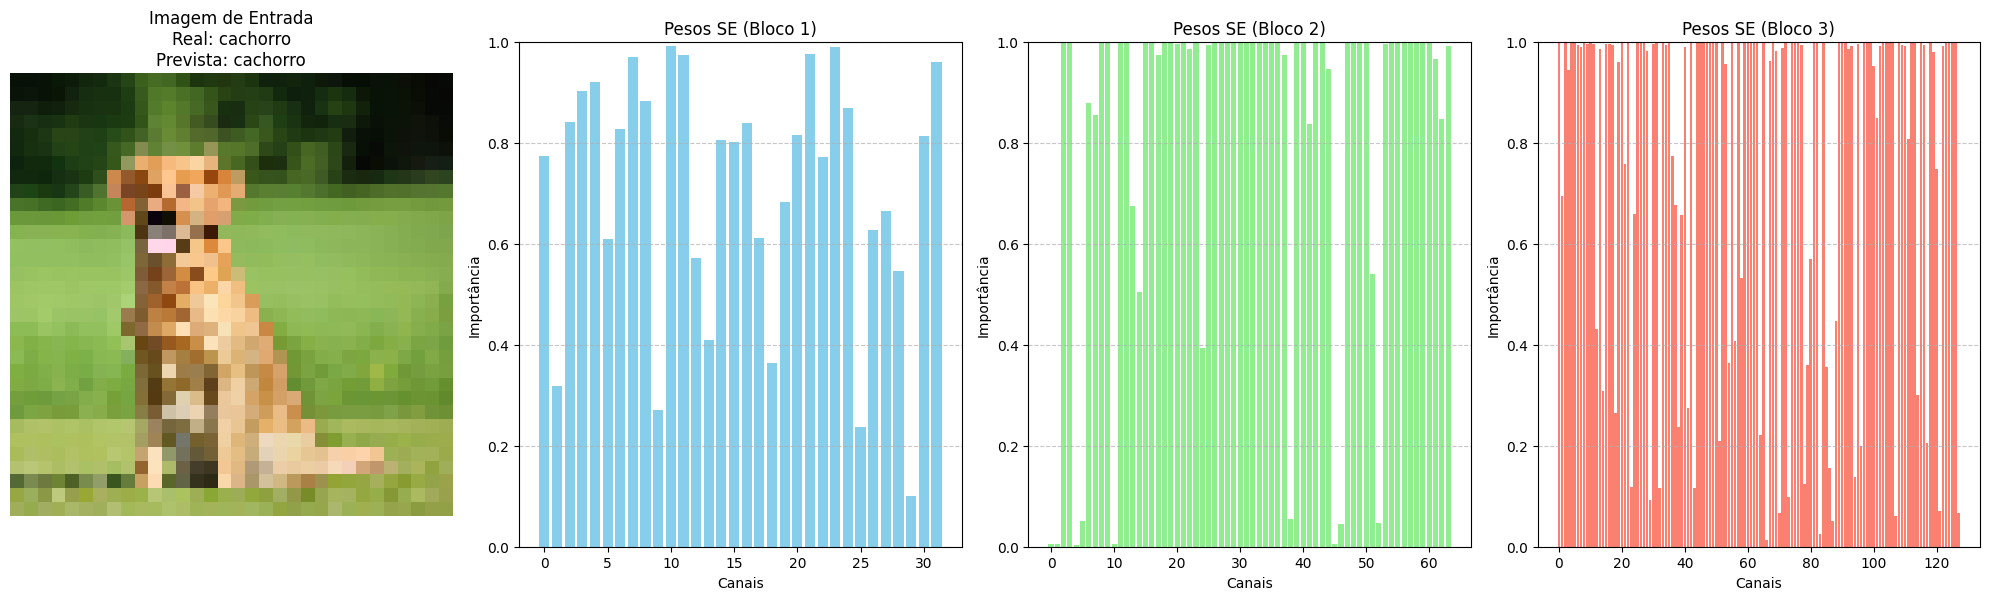

In [16]:
# -------------------------
# 7. EXECUTAR ANÁLISE COM IMAGEM EXTERNA E PREVISÃO
# -------------------------
print("🚀 Analisando uma imagem externa com previsão...")
analyze_single_image_with_prediction('/content/perro.jpg', 'cachorro')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

--- Análise da imagem ---
Etiqueta Real: gato
Classe Prevista: gato
 A previsão está CORRETA!


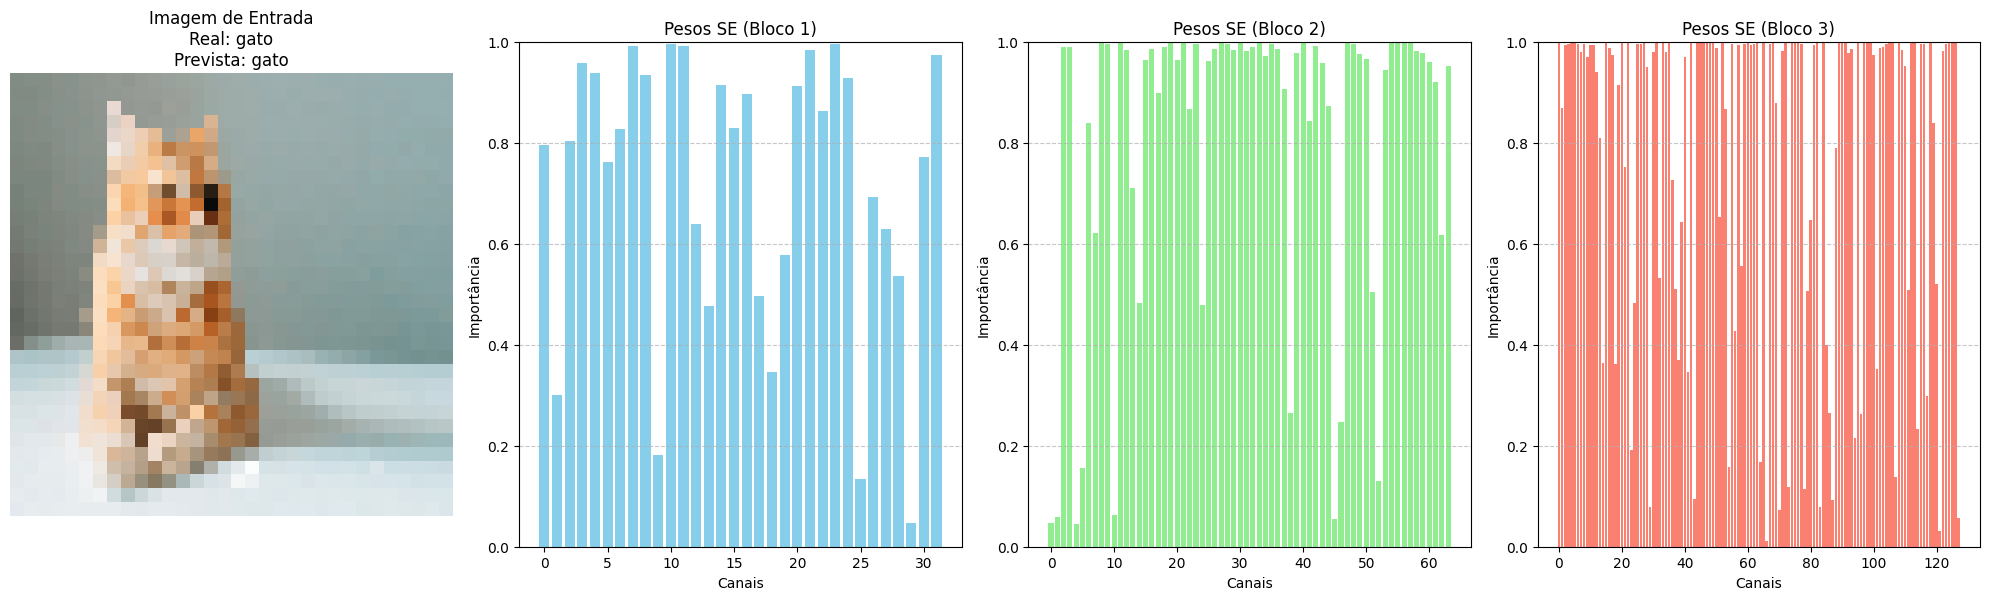

In [17]:
analyze_single_image_with_prediction('/content/gato.png', 'gato')

In [10]:
# -------------------------
# A. ANÁLISE DETALHADA DE TODAS AS CLASSES
# -------------------------
def analyze_all_classes_detailed():
    """
    Mostra os padrões de atenção médios e o desvio padrão
    dos canais para cada uma das 10 classes.
    """

    for classe in range(10):
        imgs_classe = x_test[y_test.flatten() == classe][:100]
        attn_classe_1 = se_model_1.predict(imgs_classe)
        attn_classe_2 = se_model_2.predict(imgs_classe)
        attn_classe_3 = se_model_3.predict(imgs_classe)

        mean_attn_classe_1 = np.mean(attn_classe_1, axis=0).flatten()
        mean_attn_classe_2 = np.mean(attn_classe_2, axis=0).flatten()
        mean_attn_classe_3 = np.mean(attn_classe_3, axis=0).flatten()

        plt.figure(figsize=(20, 6))

        # Gráfico de Barras para Bloco 1
        plt.subplot(1, 3, 1)
        plt.bar(range(len(mean_attn_classe_1)), mean_attn_classe_1, color='skyblue')
        plt.title(f'Classe: {class_names[classe]} - Bloco 1')
        plt.xlabel('Canais de Características')
        plt.ylabel('Importância SE (média)')
        plt.ylim(0, 1)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Gráfico de Barras para Bloco 2
        plt.subplot(1, 3, 2)
        plt.bar(range(len(mean_attn_classe_2)), mean_attn_classe_2, color='lightgreen')
        plt.title(f'Classe: {class_names[classe]} - Bloco 2')
        plt.xlabel('Canais de Características')
        plt.ylabel('Importância SE (média)')
        plt.ylim(0, 1)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Gráfico de Barras para Bloco 3
        plt.subplot(1, 3, 3)
        plt.bar(range(len(mean_attn_classe_3)), mean_attn_classe_3, color='salmon')
        plt.title(f'Classe: {class_names[classe]} - Bloco 3')
        plt.xlabel('Canais de Características')
        plt.ylabel('Importância SE (média)')
        plt.ylim(0, 1)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


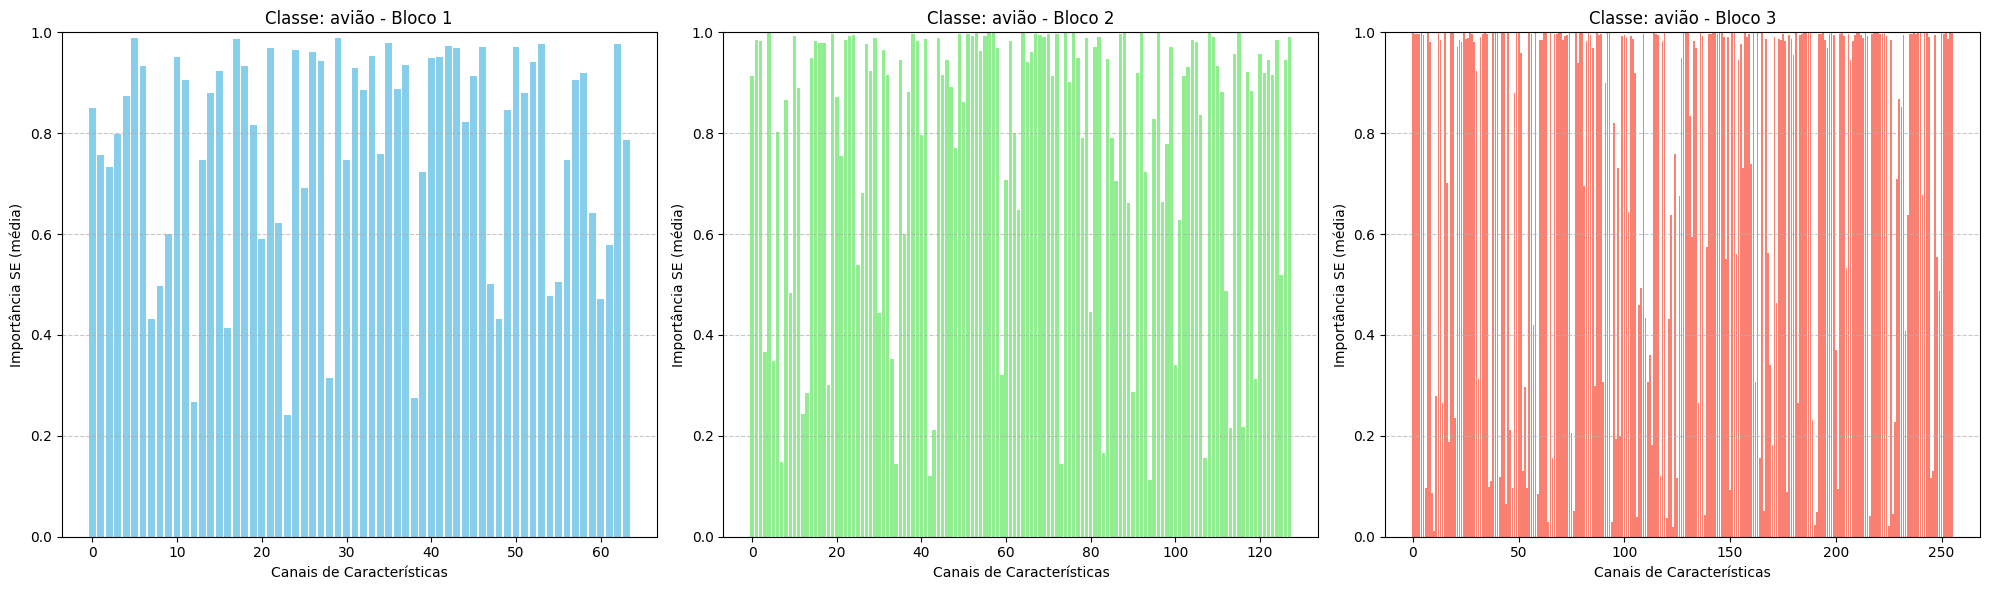

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


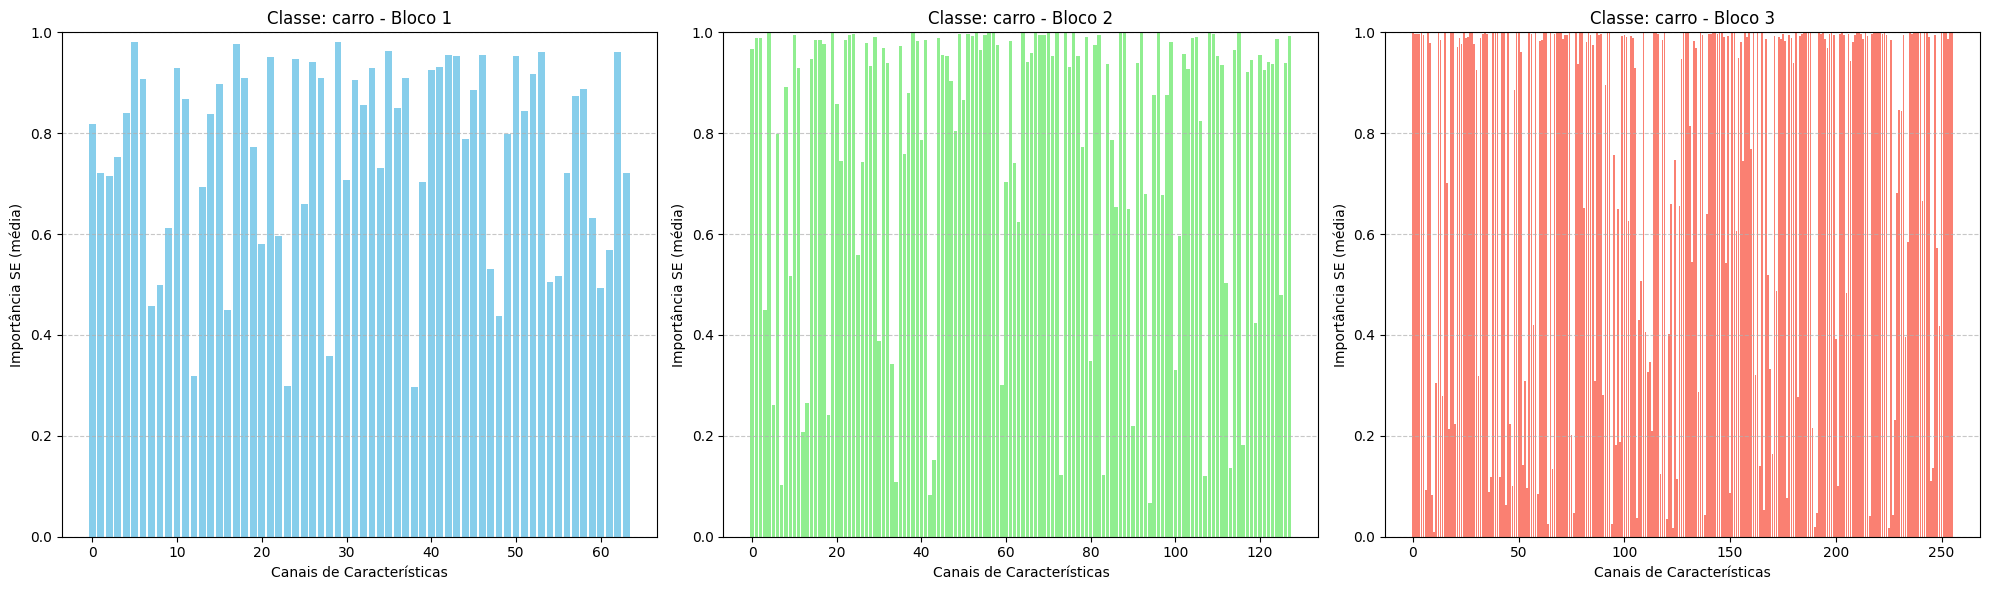

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


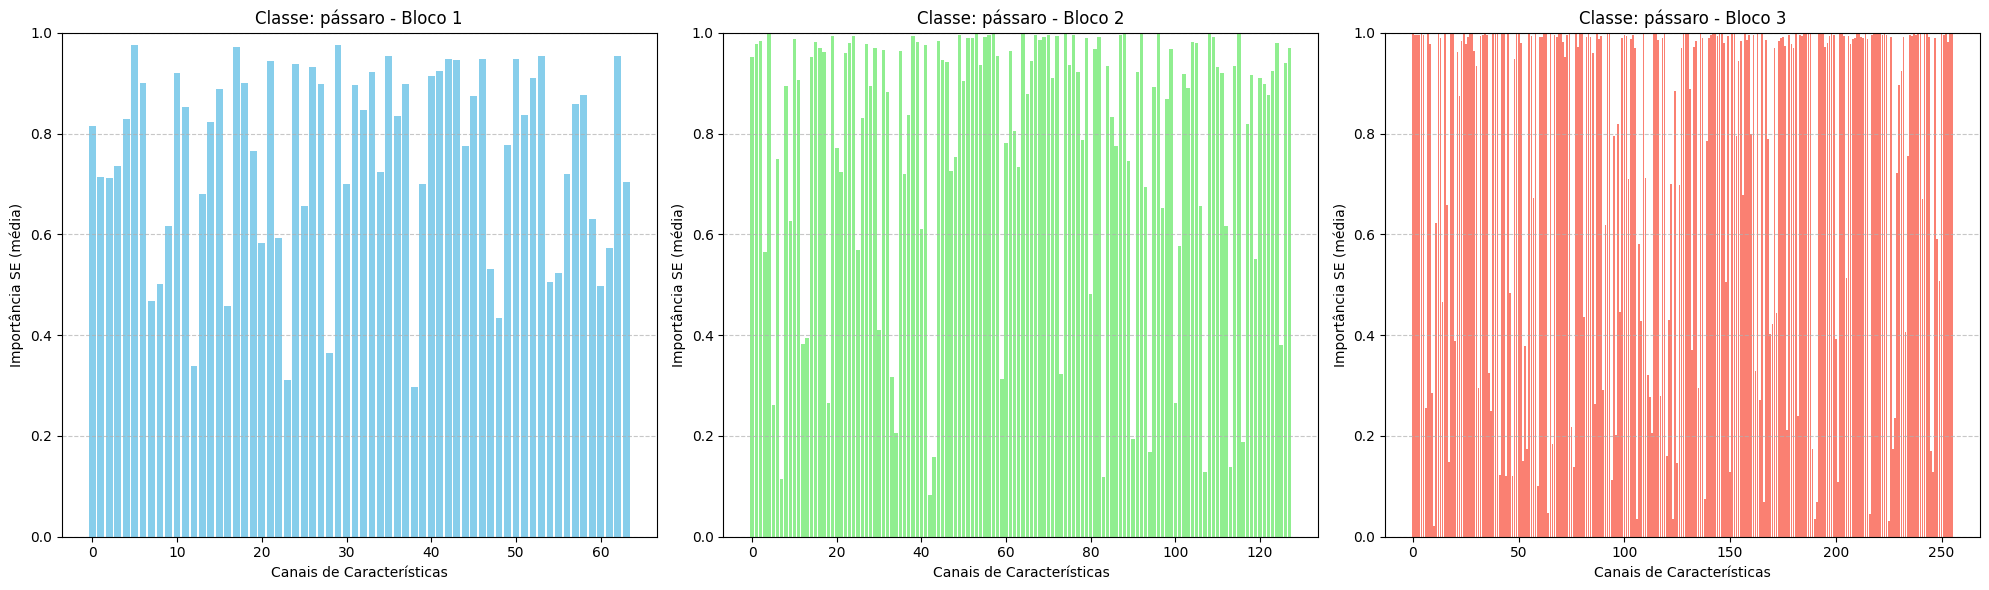

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


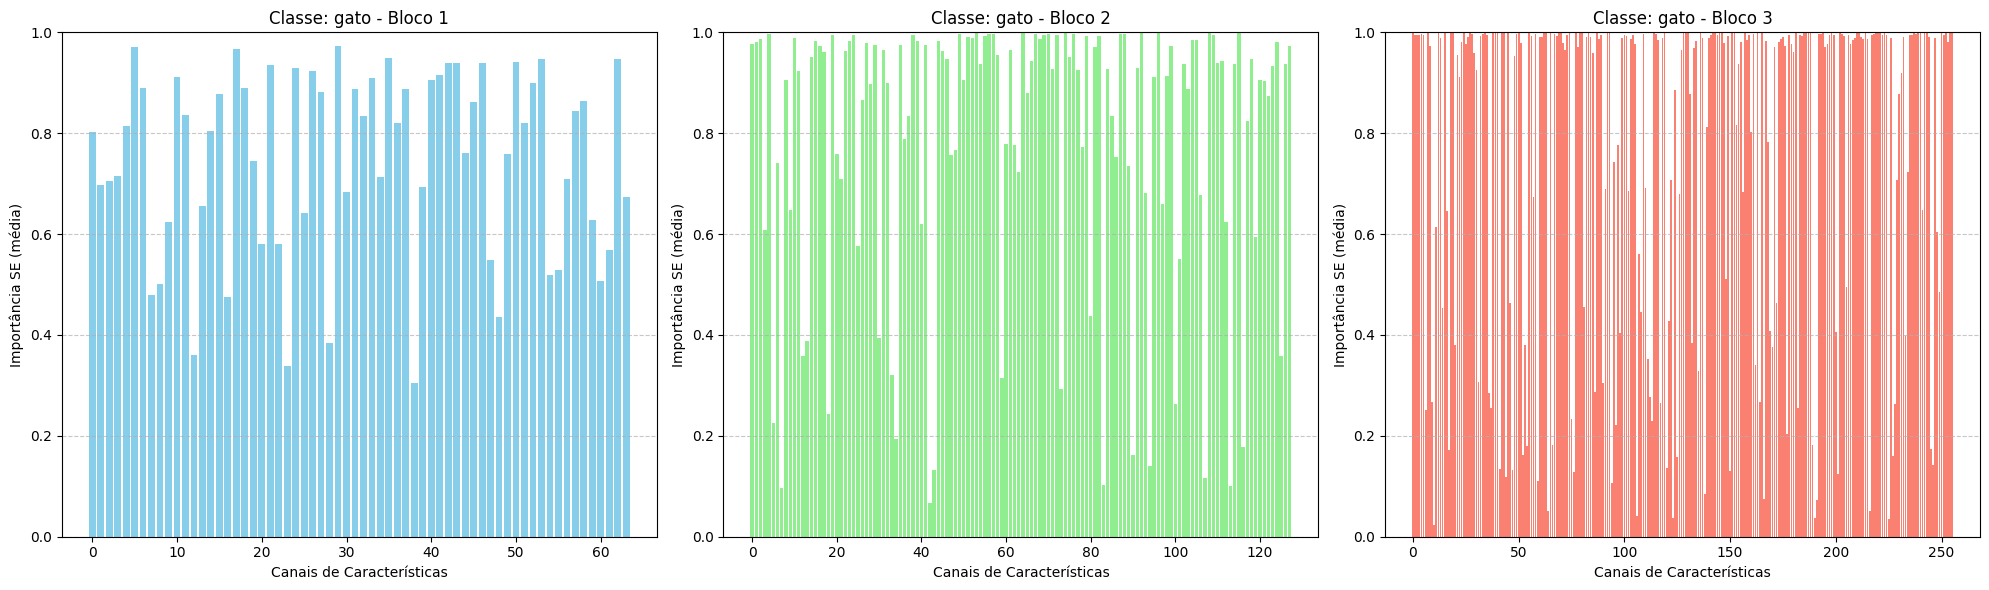

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


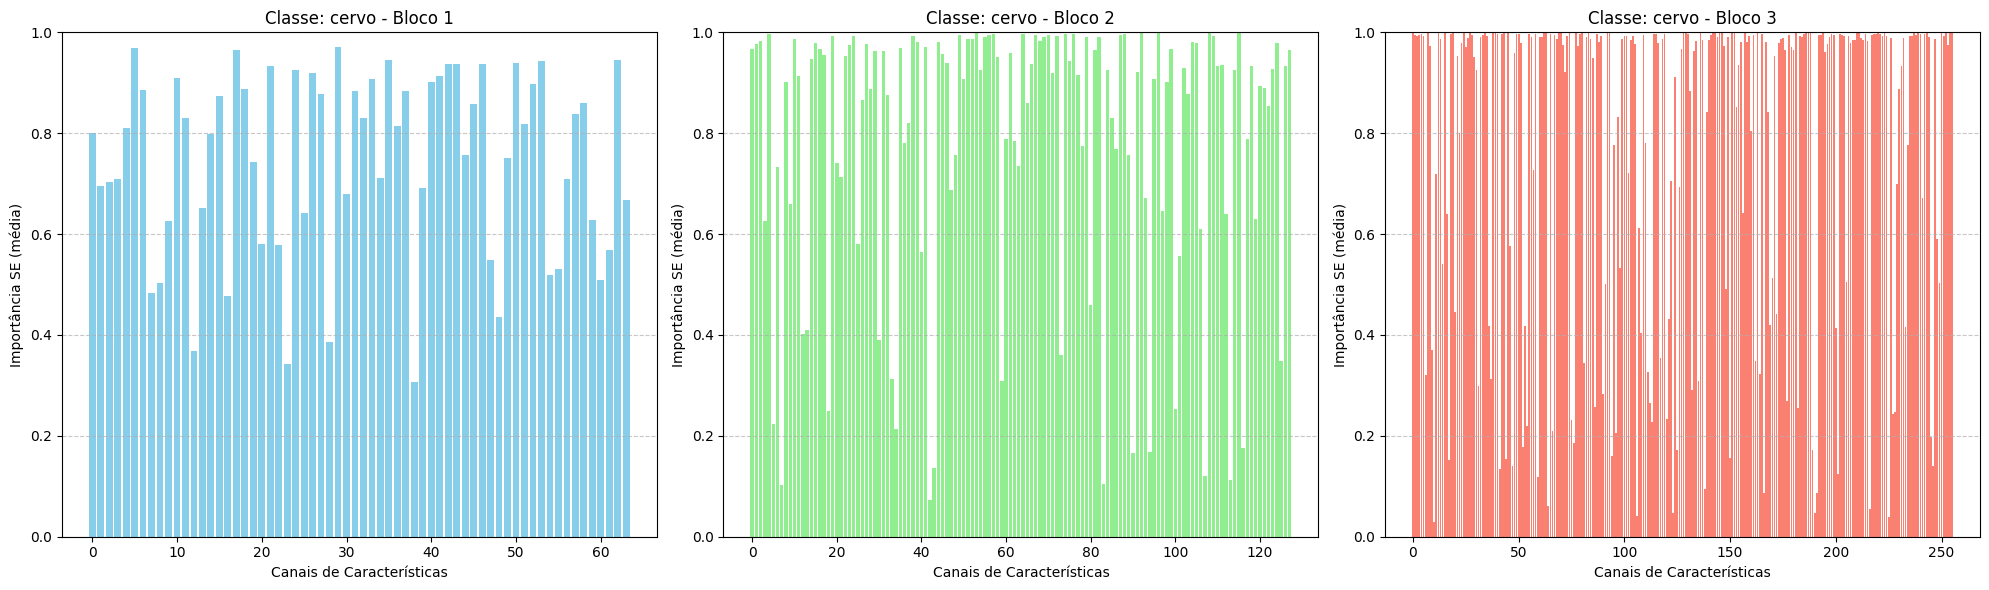

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


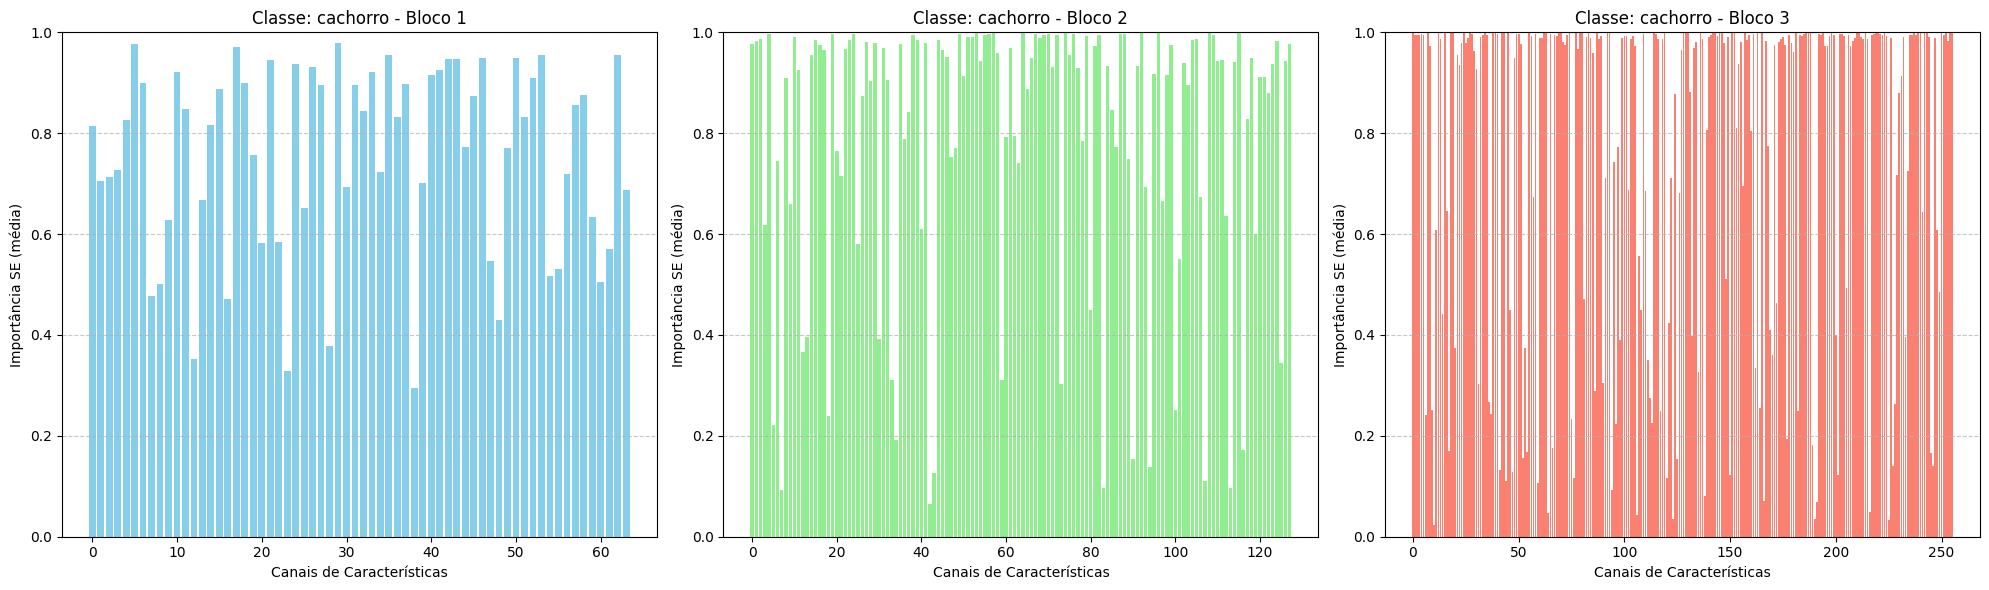

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


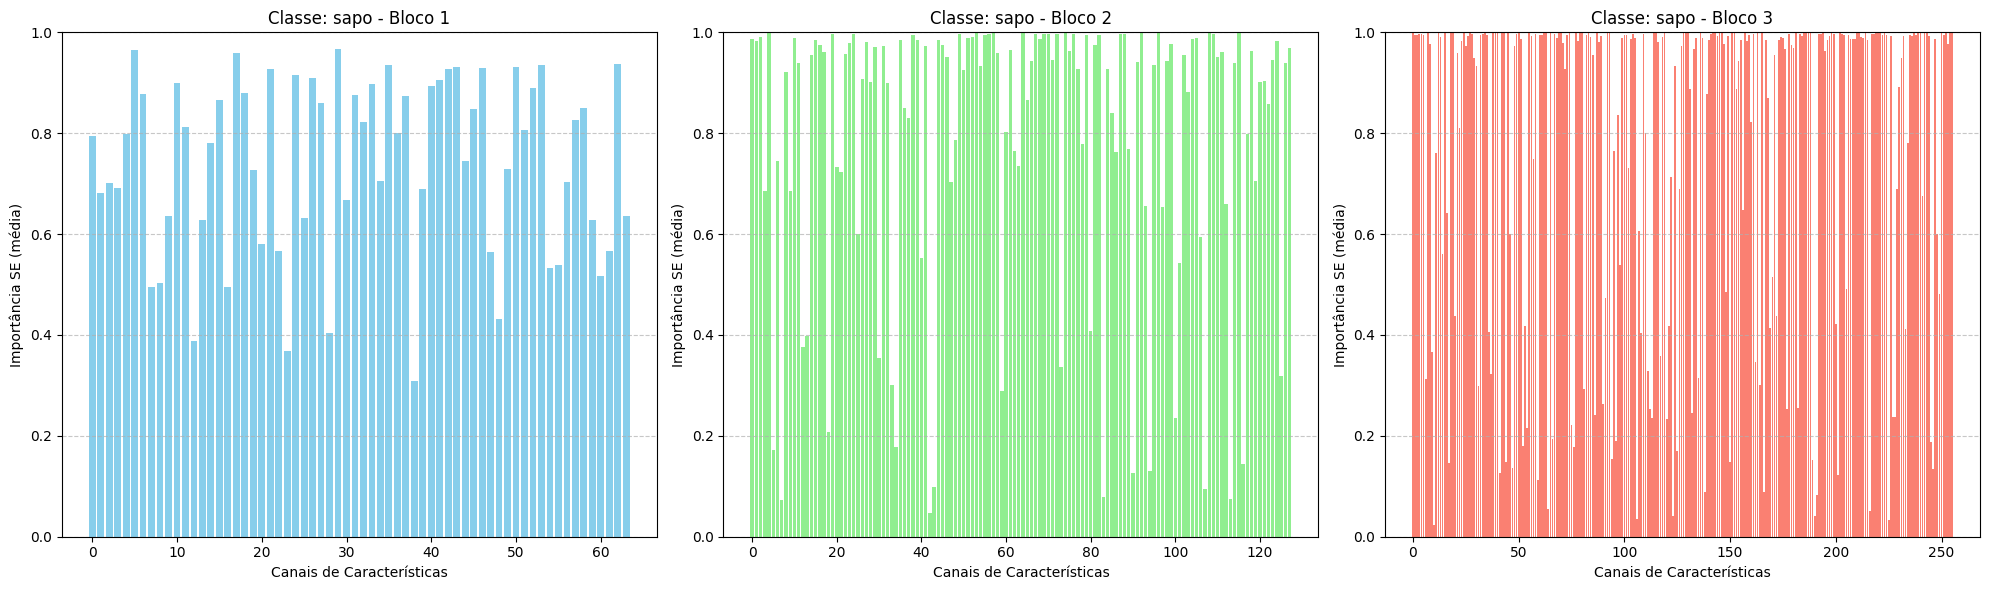

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


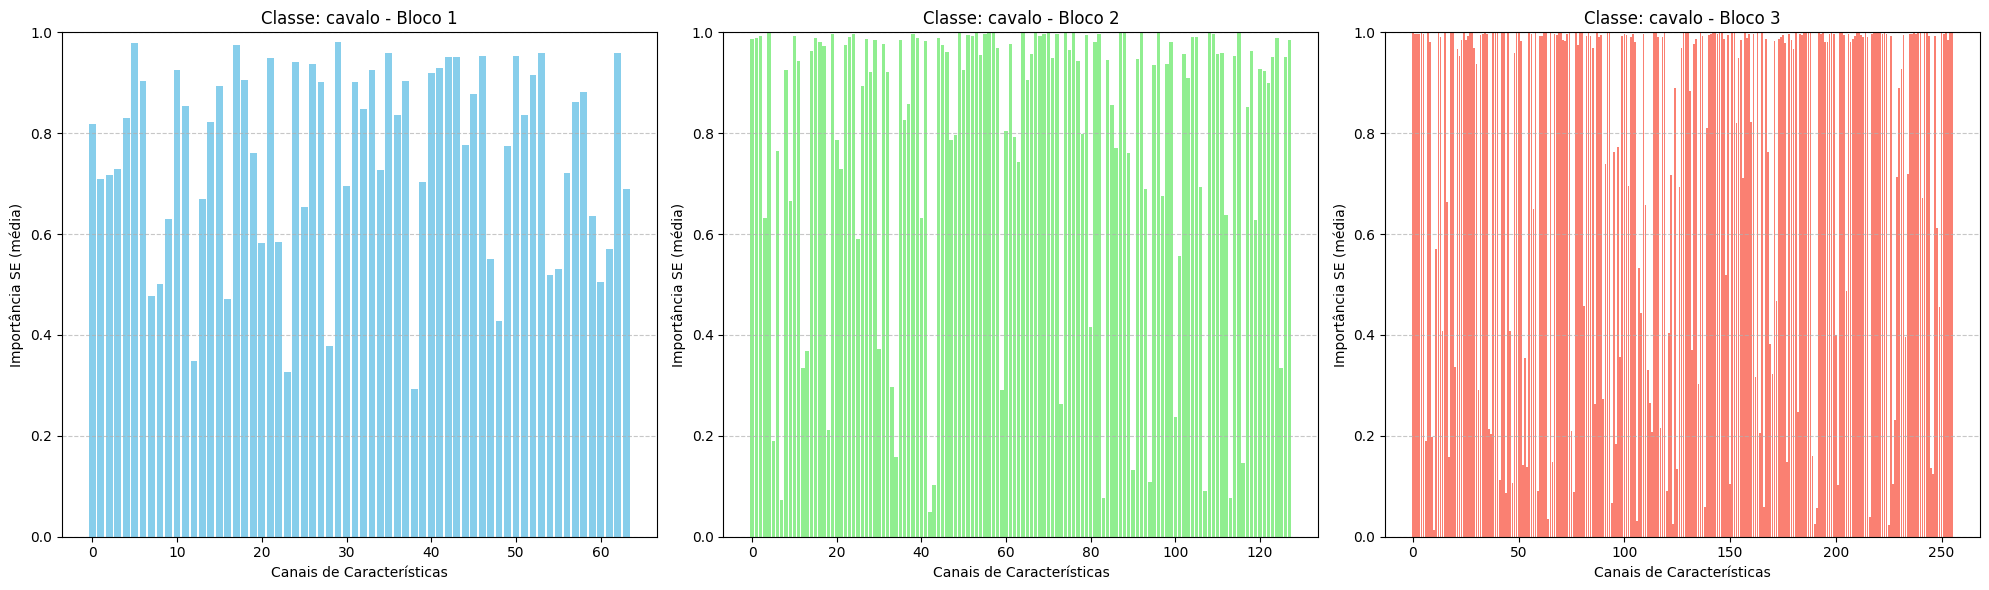

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


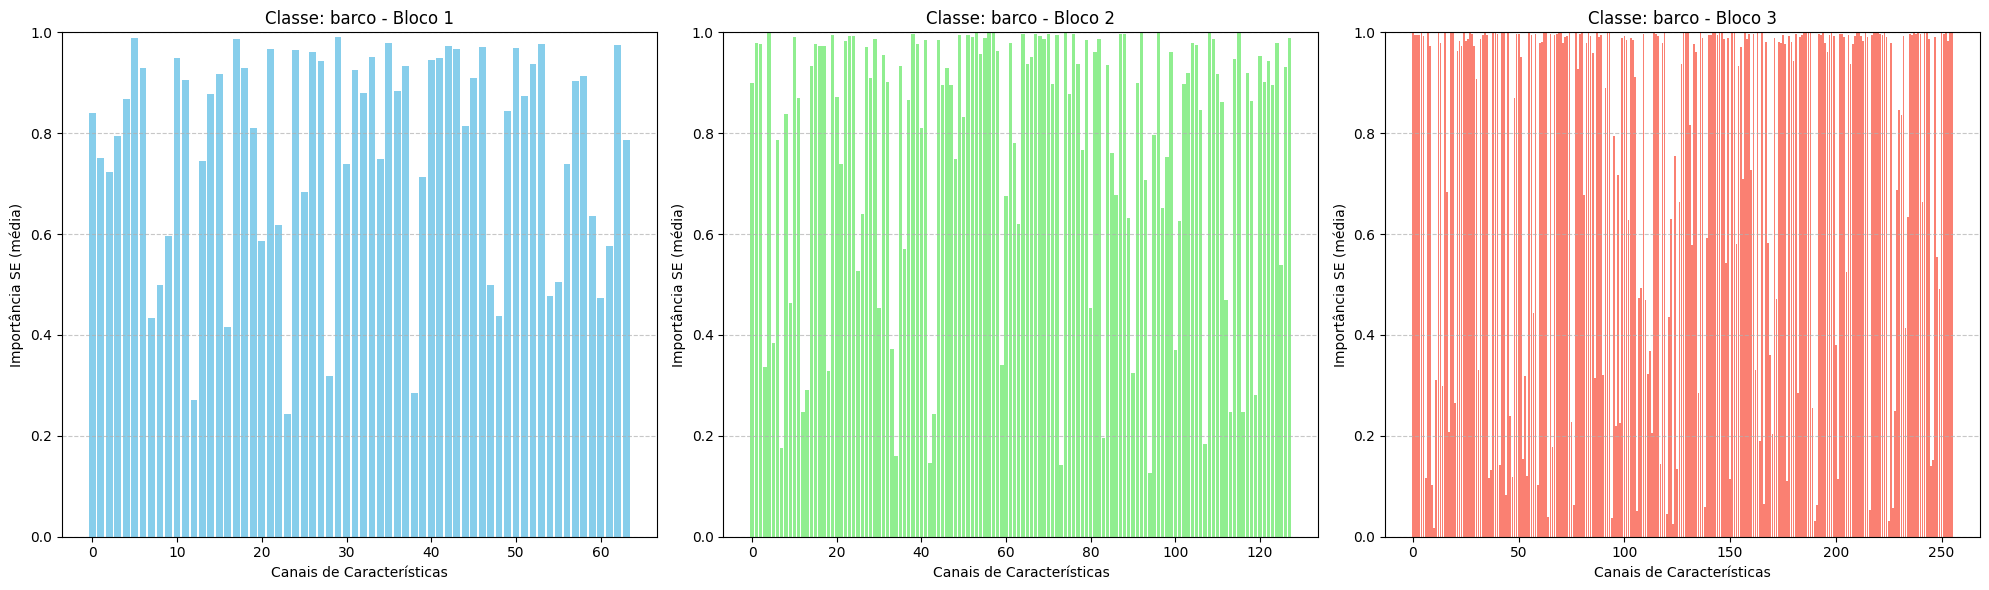

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


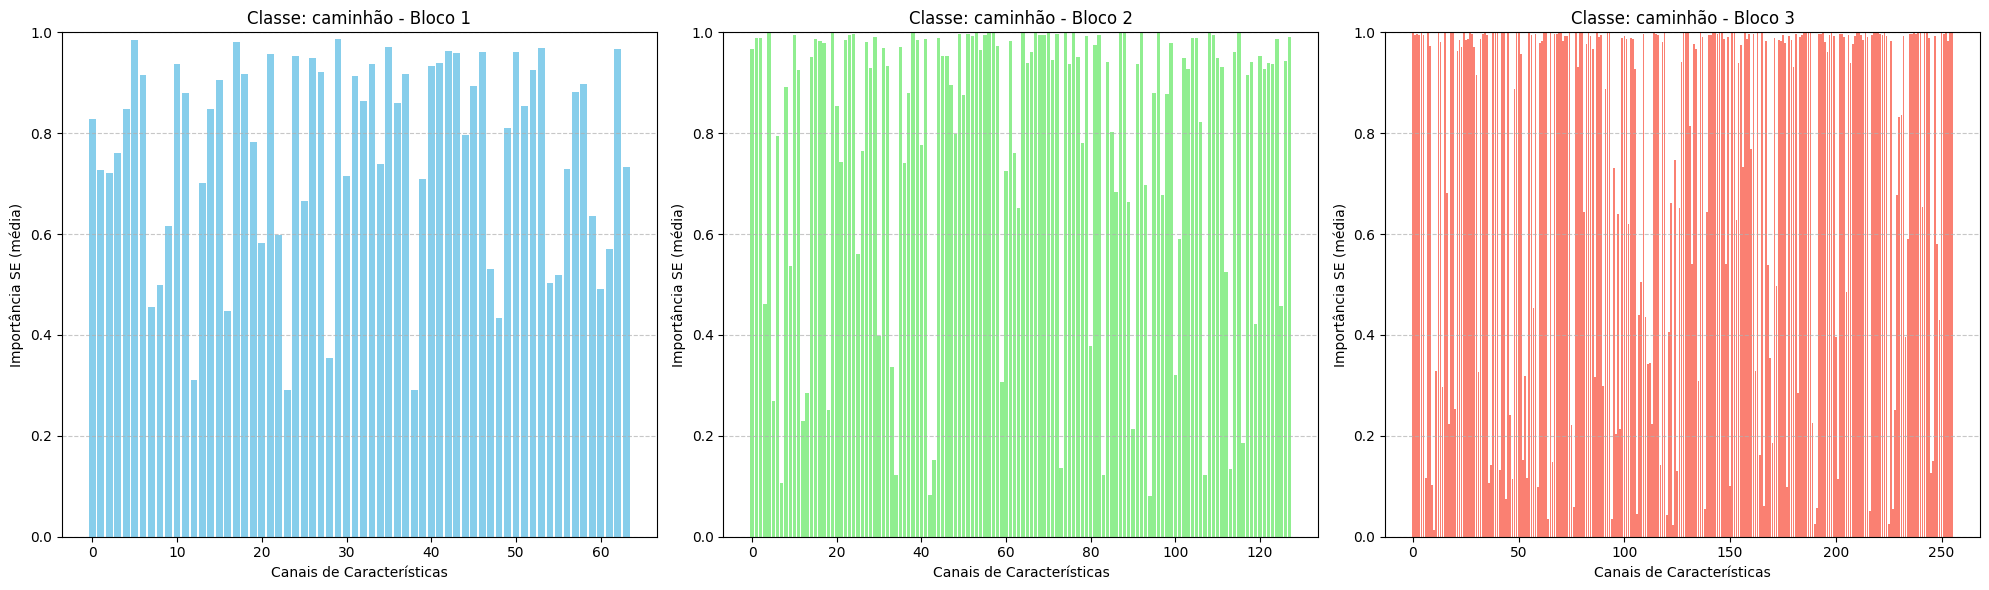

In [11]:
# Visualizar os padrões médios e desvio padrão por classe
analyze_all_classes_detailed()